In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
class ReLUActivation():
    def __init__(self):
        pass
    
    def forward(self, input):
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        relu_grad = input > 0
        return grad_output*relu_grad

In [3]:
class MLPLayer():
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [4]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    error = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return error
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [5]:
def softmax(z):
    exp_scores = np.exp(z)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
def mean_squared_error(logits,reference_answers):
    logits = softmax(logits)
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    return np.mean(np.sum((ones_for_answers - logits)*(ones_for_answers - logits), axis=1))

In [6]:
def plotXY(xy, labels=None, title="X,Y", xLabel="X", yLabel="Y", classLabel="Class"):
    x = xy[:, 0]
    y = xy[:, 1]
    if labels is None:
        labels = np.zeros(xy.shape[0])
    plotData = pd.DataFrame({xLabel: x, yLabel: y, classLabel: map(str, labels)})
    p = sns.jointplot(data=plotData, hue=classLabel, x=xLabel, y=yLabel)
    p.fig.suptitle(title)
    p.ax_joint.collections[0].set_alpha(0.8)
    p.fig.tight_layout()
    p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
    plt.show()

In [7]:
##  Normalize the ith feaature:
##            yi = (xi - mi)/si
##     mi = mean of feature i
##     si = SD of feature i
class Normalizer:
    def __init__(self, X):
        self.fit(X)
        
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        
    def fit_transfrm(self, X):
        self.fit(X)
        return self.transform(X)
    
    def transform(self, matrix):
        return (matrix-self.mean)/self.std

(3000, 2)
(3000,)
(1000, 2)
(1000,)
(2000, 2)
(2000,)


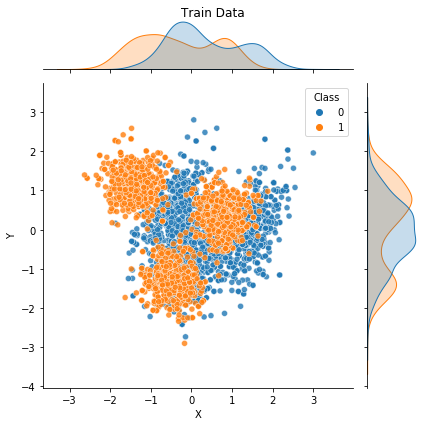

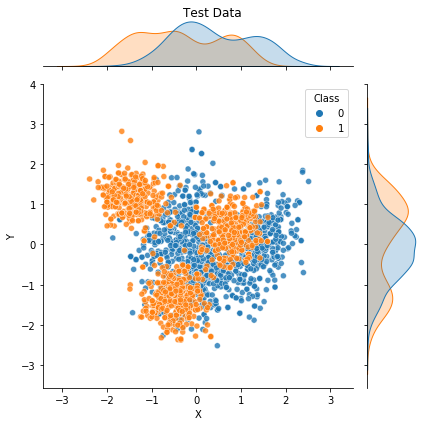

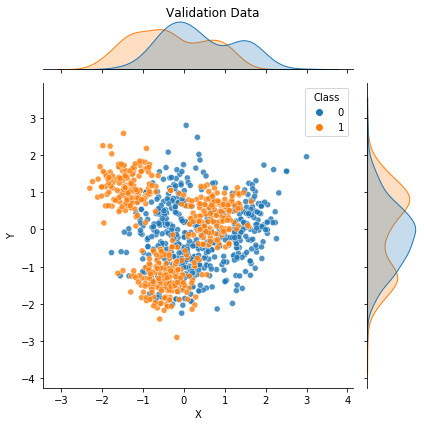

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
def load_dataset(flatten=False):
    Class1TrainData = np.genfromtxt('Train1.txt', delimiter='  ')
    Class2TrainData = np.genfromtxt('Train2.txt', delimiter='  ')
    Class1TestData = np.genfromtxt('Test1.txt', delimiter='  ')
    Class2TestData = np.genfromtxt('Test2.txt', delimiter='  ')
    X_train = np.concatenate([Class1TrainData[:1500, :], Class2TrainData[:1500, :], Class1TrainData[1500:, :], Class2TrainData[1500:, :]])
    y_train = np.array(([0]*1500)+([1]*1500)+([0]*500)+([1]*500))
    (X_test, y_test) = (np.concatenate([Class1TestData,Class2TestData]),np.array(([0]*len(Class1TestData))+([1]*len(Class2TestData))))
    # normalize x
    #X_train = X_train.astype(float) / 255.
    #X_test = X_test.astype(float) / 255. 
    # we reserve the last 1000 training examples for validation
    X_train, X_val = X_train[:-1000], X_train[-1000:]
    y_train, y_val = y_train[:-1000], y_train[-1000:]
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
normalizer = Normalizer(X_train)
X_train = normalizer.transform(X_train)
X_test = normalizer.transform(X_test)
X_val = normalizer.transform(X_val)
for mat in (X_train, y_train, X_val, y_val, X_test, y_test):
    print(mat.shape)
## Let's look at some example
plotXY(X_train, labels=y_train, title="Train Data", xLabel="X", yLabel="Y", classLabel="Class")
plotXY(X_test, labels=y_test, title="Test Data", xLabel="X", yLabel="Y", classLabel="Class")
plotXY(X_val, labels=y_val, title="Validation Data", xLabel="X", yLabel="Y", classLabel="Class")

In [9]:
class MLP:
    def __init__(self, dimensions=2, hiddenNodes=4, classes=2, learning_rate=0.1):
        self.dimensions = dimensions
        self.hiddenNodes = hiddenNodes
        self.classes = classes
        self.learning_rate = learning_rate
        self.network = []
        self.network.append(MLPLayer(dimensions,hiddenNodes,learning_rate=learning_rate))
        self.network.append(ReLUActivation())
        self.network.append(MLPLayer(hiddenNodes,classes,learning_rate=learning_rate))
    def forward(self, X):
        activations = []
        input = X
        for l in self.network:
            activations.append(l.forward(input))
            input = activations[-1]

        assert len(activations) == len(self.network)
        return activations
    def predict(self,X):
        logits = self.forward(X)[-1]
        return logits.argmax(axis=-1)

    def validate(self,X, y):
        logits = self.forward(X)[-1]

        loss = mean_squared_error(logits,y)
        return np.mean(loss)
    
    def train(self,X,y):
        layer_activations = self.forward(X)
        layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
        logits = layer_activations[-1]

        loss = softmax_crossentropy_with_logits(logits,y)
        loss_grad = grad_softmax_crossentropy_with_logits(logits,y)

        for layer_index in range(len(self.network))[::-1]:
            layer = self.network[layer_index]

            loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates

        return np.mean(loss)


MLP with  2  hidden nodes converged in  31  epochs
Train Loss: 0.41
Val Loss: 0.41
Test Loss: 0.4
Train Accuracy: 0.65
Val Accuracy: 0.66
Test Accuracy: 0.67


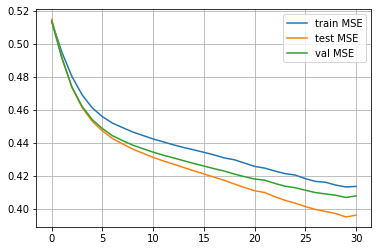

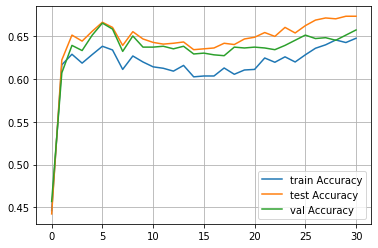

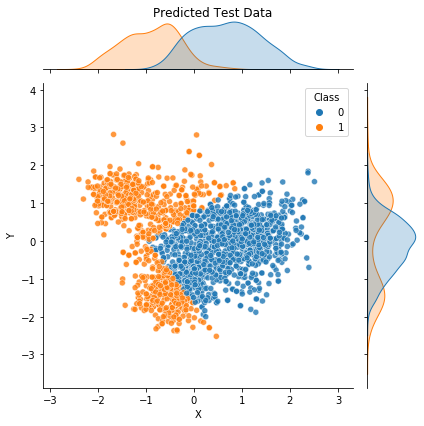


MLP with  4  hidden nodes converged in  59  epochs
Train Loss: 0.31
Val Loss: 0.32
Test Loss: 0.3
Train Accuracy: 0.78
Val Accuracy: 0.77
Test Accuracy: 0.8


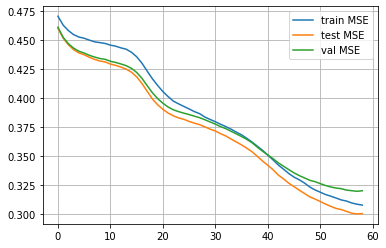

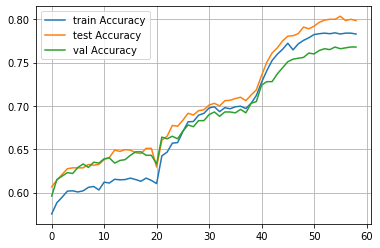

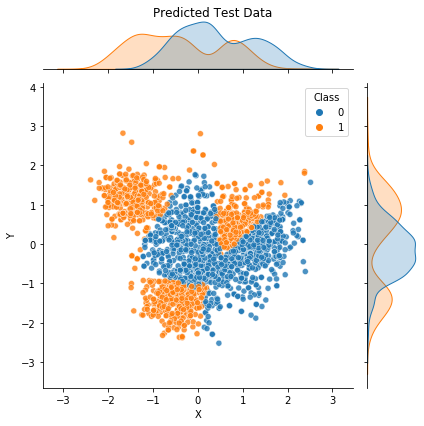


MLP with  6  hidden nodes converged in  47  epochs
Train Loss: 0.3
Val Loss: 0.31
Test Loss: 0.29
Train Accuracy: 0.79
Val Accuracy: 0.77
Test Accuracy: 0.8


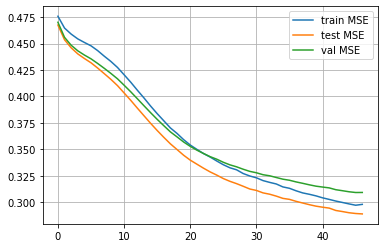

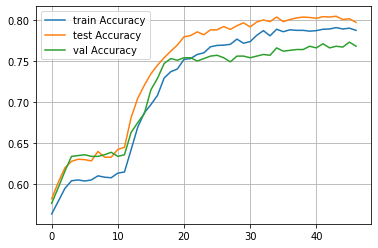

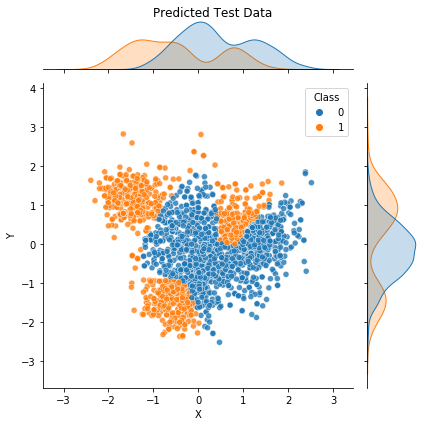


MLP with  8  hidden nodes converged in  15  epochs
Train Loss: 0.4
Val Loss: 0.4
Test Loss: 0.38
Train Accuracy: 0.66
Val Accuracy: 0.66
Test Accuracy: 0.68


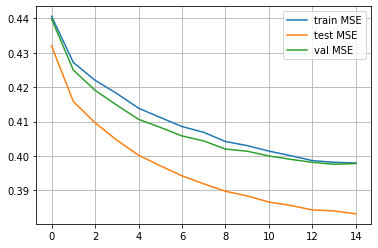

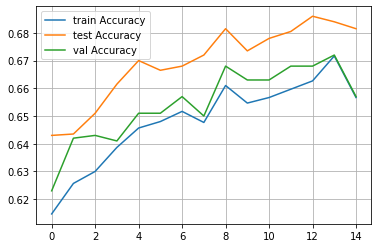

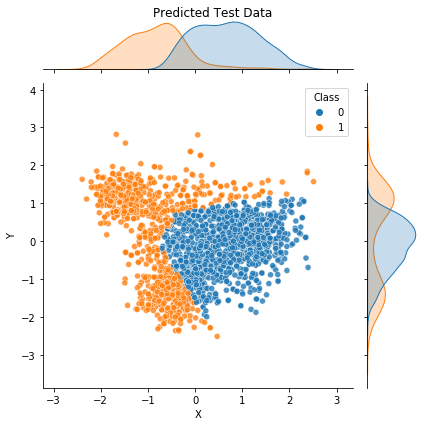


MLP with  10  hidden nodes converged in  47  epochs
Train Loss: 0.3
Val Loss: 0.31
Test Loss: 0.29
Train Accuracy: 0.79
Val Accuracy: 0.77
Test Accuracy: 0.8


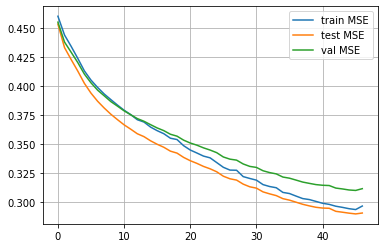

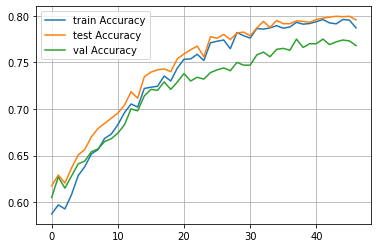

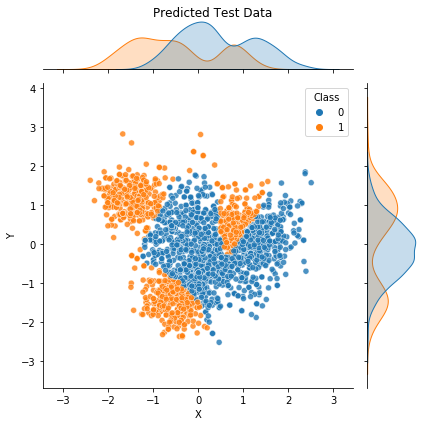

In [10]:
import os

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        
def getTrainedModel(hiddenNodesList):
    models={}
    for hiddenNodes in hiddenNodesList:
        model = {}
        model["test_log"] = []
        model["train_log"] = []
        model["val_log"] = []
        model["train_loss"] = []
        model["val_loss"] = []
        model["test_loss"] = []
        model["trained"] = False
        model["model"] = MLP(hiddenNodes = hiddenNodes)
        models[hiddenNodes] = model
        
    for epoch in range(100):
        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=128,shuffle=True):
            for hiddenNodes in models:
                if not models[hiddenNodes]["trained"]:
                    models[hiddenNodes]["model"].train(x_batch,y_batch)
        os.system( 'cls' )
        for hiddenNodes in models:
            if not models[hiddenNodes]["trained"]:
                mlp = models[hiddenNodes]["model"]
                models[hiddenNodes]["train_loss"].append(mlp.validate(X_train,y_train))
                models[hiddenNodes]["val_loss"].append(mlp.validate(X_val,y_val))
                models[hiddenNodes]["test_loss"].append(mlp.validate(X_test,y_test))

                models[hiddenNodes]["test_log"].append(np.mean(mlp.predict(X_test)==y_test))
                models[hiddenNodes]["train_log"].append(np.mean(mlp.predict(X_train)==y_train))
                models[hiddenNodes]["val_log"].append(np.mean(mlp.predict(X_val)==y_val))
                models[hiddenNodes]["trained"] = len(models[hiddenNodes]["val_loss"])>5 and (np.mean(models[hiddenNodes]["val_loss"][-5:])-models[hiddenNodes]["val_loss"][-1])<0.001
    return models

trainedModels = getTrainedModel([2,4,6,8,10]);
for hidddenNodes, model in trainedModels.items():
    mlp = model["model"]        
    test_log = model["test_log"]
    train_log = model["train_log"]
    val_log = model["val_log"]
    train_loss = model["train_loss"]
    val_loss = model["val_loss"]
    test_loss = model["test_loss"]
    print()
    print("MLP with ", hidddenNodes," hidden nodes converged in ",len(train_loss), " epochs")
    print("Train Loss:",round(train_loss[-1], 2))
    print("Val Loss:",round(val_loss[-1], 2))
    print("Test Loss:",round(test_loss[-1], 2))
    print("Train Accuracy:",round(train_log[-1], 2))
    print("Val Accuracy:",round(val_log[-1], 2))
    print("Test Accuracy:",round(test_log[-1], 2))
    plt.figure("MSE")
    plt.plot(train_loss,label='train MSE')
    plt.plot(test_loss,label='test MSE')
    plt.plot(val_loss,label='val MSE')
    plt.legend(loc='best')
    plt.grid()
    plt.show()    
    plt.plot(train_log,label='train Accuracy')
    plt.plot(test_log,label='test Accuracy')
    plt.plot(val_log,label='val Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    #plotXY(X_train, labels=mlp.predict(X_train), title="Predicted Train Data", xLabel="X", yLabel="Y", classLabel="Class")
    plotXY(X_test, labels=mlp.predict(X_test), title="Predicted Test Data", xLabel="X", yLabel="Y", classLabel="Class")
    #plotXY(X_val, labels=mlp.predict(X_val), title="Predicted Validation Data", xLabel="X", yLabel="Y", classLabel="Class")
    